
# Example 2: Synthetic Data Fit

In this example, we compare the DRD model to the Mann model, using the three IEC-recommended Mann model
parameters: $L/\text{zref}=0.59, Γ=3.9, αϵ^{2/3}=3.2 * (\text{zref}^{2/3} / \text{ustar}^2)$.
In this example, the exponent $\nu=-\frac{1}{3}$ is fixed so that $\tau(\boldsymbol{k})$
matches the slope of $\tau^{IEC}$ for in the energy-containing range, $k \rightarrow 0$.

The following example is also discussed in the [original DRD paper](https://arxiv.org/abs/2107.11046).


## Import packages

First, we import the packages we need for this example. Additionally, we choose to use
CUDA if it is available.



In [1]:
import torch
import torch.nn as nn

from drdmannturb import EddyLifetimeType
from drdmannturb.parameters import (
    LossParameters,
    NNParameters,
    PhysicalParameters,
    ProblemParameters,
)
from drdmannturb.spectra_fitting import CalibrationProblem, OnePointSpectraDataGenerator

device = "cuda" if torch.cuda.is_available() else "cpu"

if torch.cuda.is_available():
    torch.set_default_tensor_type("torch.cuda.FloatTensor")

## Setting Physical Parameters
The following cell sets the necessary physical parameters

$L$ is our characteristic length scale, $\Gamma$ is our characteristic
time scale, and $\sigma = \alpha\epsilon^{2/3}$ is the spectrum amplitude.



In [2]:
zref = 90  # reference height
z0 = 0.02
zref = 90
uref = 11.4
ustar = 0.556  # friction velocity

# Scales associated with Kaimal spectrum
L = 0.593 * zref  # length scale
Gamma = 3.89  # time scale
sigma = 3.2 * ustar**2.0 / zref ** (2.0 / 3.0)  # magnitude (σ = αϵ^{2/3})

print(f"Physical Parameters: {L,Gamma,sigma}")

k1 = torch.logspace(-1, 2, 20) / zref

Physical Parameters: (53.37, 3.89, 0.04925737023046032)


## ``CalibrationProblem`` construction

We'll use a simple neural network consisting of two layers with $10$ neurons each,
connected by a ReLU activation function. The parameters determining the network
architecture can conveniently be set through the ``NNParameters`` dataclass.

Using the ``ProblemParameters`` dataclass, we indicate the eddy lifetime function
$\tau$ substitution, that we do not intend to learn the exponent $\nu$,
and that we would like to train for 10 epochs, or until the tolerance ``tol`` loss (0.001 by default),
whichever is reached first.

Having set our physical parameters above, we need only pass these to the
``PhysicalParameters`` dataclass just as is done below.

Lastly, using the ``LossParameters`` dataclass, we introduce a second-order
derivative penalty term with weight $\alpha_2 = 1$ and a
network parameter regularization term with weight
$\beta=10^{-5}$ to our MSE loss function.




In [3]:
pb = CalibrationProblem(
    nn_params=NNParameters(
        nlayers=2,
        # Specifying the hidden layer sizes is done by passing a list of integers, as seen here.
        hidden_layer_sizes=[10, 10],
        # Specifying the activations is done similarly.
        activations=[nn.ReLU(), nn.ReLU()],
    ),
    prob_params=ProblemParameters(
        nepochs=10, learn_nu=False, eddy_lifetime=EddyLifetimeType.TAUNET
    ),
    # Note that we have not activated the first order term, but this can be done by passing a value for ``alpha_pen1``
    loss_params=LossParameters(alpha_pen2=1.0, beta_reg=1.0e-5),
    phys_params=PhysicalParameters(
        L=L, Gamma=Gamma, sigma=sigma, ustar=ustar, domain=k1
    ),
    logging_directory="runs/synthetic_fit",
    device=device,
)

## Data Generation
We now collect ``Data = (<data points>, <data values>)`` and specify the
reference height (``zref``) to be used during calibration. Note that ``DataType.KAIMAL``
is used by default.



In [4]:
Data = OnePointSpectraDataGenerator(data_points=k1, zref=zref, ustar=ustar).Data

## Calibration
Now, we fit our model. ``CalibrationProblem.calibrate`` takes the tuple ``Data``
which we just constructed and performs a typical training loop.



In [5]:
optimal_parameters = pb.calibrate(data=Data)

pb.print_calibrated_params()

Initial loss: 0.04606855911763526


  0%|                                                                         | 0/10 [00:00<?, ?it/s]

 10%|██████▌                                                          | 1/10 [00:03<00:32,  3.65s/it]

 20%|█████████████                                                    | 2/10 [00:05<00:21,  2.65s/it]

 30%|███████████████████▌                                             | 3/10 [00:07<00:16,  2.37s/it]

 40%|██████████████████████████                                       | 4/10 [00:09<00:13,  2.24s/it]

 50%|████████████████████████████████▌                                | 5/10 [00:11<00:10,  2.17s/it]

 60%|███████████████████████████████████████                          | 6/10 [00:13<00:08,  2.12s/it]

 70%|█████████████████████████████████████████████▌                   | 7/10 [00:15<00:06,  2.07s/it]

 80%|████████████████████████████████████████████████████             | 8/10 [00:17<00:04,  2.06s/it]

 90%|██████████████████████████████████████████████████████████▌      | 9/10 [00:19<00:02,  2.08s/it]

100%|████████████████████████████████████████████████████████████████| 10/10 [00:21<00:00,  2.07s/it]

100%|████████████████████████████████████████████████████████████████| 10/10 [00:21<00:00,  2.19s/it]

Spectra fitting concluded with final loss: 0.008501029301051776
Optimal calibrated L        :  54.5565 
Optimal calibrated Γ        :   1.4951 
Optimal calibrated αϵ^{2/3} :   0.0460 


## Plotting
``DRDMannTurb`` offers built-in plotting utilities and Tensorboard integration
which make visualizing results and various aspects of training performance
very simple.

The following will plot the fit.



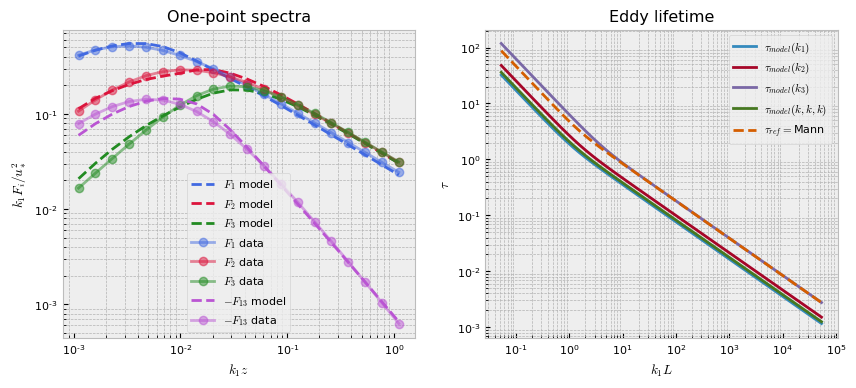

In [6]:
pb.plot()

This plots out the loss function terms as specified, each multiplied by the
respective coefficient hyperparameter. The training logs can be accessed from the logging directory
with Tensorboard utilities, but we also provide a simple internal utility for a single
training log plot.



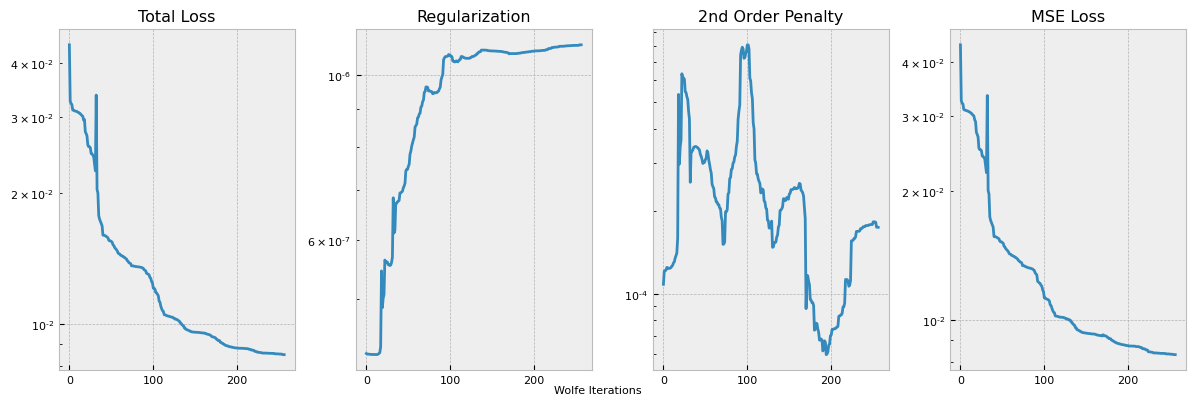

In [7]:
pb.plot_losses(run_number=0)

## Save Model with Problem Metadata
Here, we'll make use of the model saving utilities,
which make saving the ``DRDMannTurb`` fit very straightforward. The following line
automatically pickles and writes out a trained model along with the various
parameter dataclasses in ``../results``.



In [8]:
pb.save_model("./outputs/")

## Loading Model and Problem Metadata
Lastly, we load our model back in.



In [9]:
import pickle

path_to_parameters = "./outputs/EddyLifetimeType.TAUNET_DataType.KAIMAL.pkl"

with open(path_to_parameters, "rb") as file:
    (
        nn_params,
        prob_params,
        loss_params,
        phys_params,
        model_params,
    ) = pickle.load(file)

### Recovering Old Model Configuration and Old Parameters
We can also load the old model configuration from file and create a new ``CalibrationProblem`` object from the
stored network parameters and metadata.



In [10]:
pb_new = CalibrationProblem(
    nn_params=nn_params,
    prob_params=prob_params,
    loss_params=loss_params,
    phys_params=phys_params,
    device=device,
)

pb_new.parameters = model_params

import numpy as np

assert np.ma.allequal(pb.parameters, pb_new.parameters)